In [1]:
import os
import random
import numpy as np
import pandas as pd
import re

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Fix Seed
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)

In [3]:
# Load Data
train = pd.read_csv('./train.csv').drop('ID', axis=1)
test = pd.read_csv('./test.csv').drop('ID', axis=1)
submission = pd.read_csv('./sample_submission.csv')

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flt.DESKTOP-
[nltk_data]     I2KQP96\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flt.DESKTOP-
[nltk_data]     I2KQP96\AppData\Roaming\nltk_data...


True

In [5]:
# 문자열 전처리
cols = ['first_party', 'second_party', 'facts']
shortword = re.compile(r'\W*\b\w{1}\b')
tokenizer = TreebankWordTokenizer()
stopword = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# 전처리 함수 1
def preprocessing(df, cols, shortword, tokenizer, stopword, lemmatizer):
    first_party_lst = []
    second_party_lst = []
    facts_lst = []
    for col in cols:
        # 좌우 공백 제거
        df[col] = df[col].str.strip()
        # 두 칸 이상의 공백 한 칸으로 변경
        df[col] = df[col].str.replace('  ', ' ')
        # 소문자로 변경
        df[col] = df[col].str.lower()
        # ",", "." 제거
        df[col] = df[col].str.replace(',','')
        df[col] = df[col].str.replace('.','')

        if col == 'first_party':
            for sample in df[col]:
                # 한글자 단어 제거
                sample = shortword.sub('', sample)
                # 특수문자 제거
                sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                # tokenzier를 이용한 단어 토큰화
                token = tokenizer.tokenize(sample)
                # 불용어 제거
                new_token = []
                for tok in token:
                    if tok not in stopword:
                        # 표제어 추출
                        new_token.append(lemmatizer.lemmatize(tok, 'n'))
                first_party_lst.append(new_token)
            # sklearn.feature_extraction 변환을 위해 단어들을 결합
            for i in range(len(first_party_lst)):
                first_party_lst[i] = ' '.join(first_party_lst[i])

        elif col == 'second_party':
            for sample in df[col]:
                # 한글자 단어 제거
                sample = shortword.sub('', sample)
                # 특수문자 제거
                sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                # tokenzier를 이용한 단어 토큰화
                token = tokenizer.tokenize(sample)
                # 불용어 제거
                new_token = []
                for tok in token:
                    if tok not in stopword:
                        # 표제어 추출
                        new_token.append(lemmatizer.lemmatize(tok, 'n'))
                second_party_lst.append(new_token)
            # sklearn.feature_extraction 변환을 위해 단어들을 결합
            for i in range(len(second_party_lst)):
                second_party_lst[i] = ' '.join(second_party_lst[i])

        elif col=='facts':
            for sample in df[col]:
                # 한글자 단어 제거
                sample = shortword.sub('', sample)
                # 특수문자 제거
                sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                # tokenzier를 이용한 단어 토큰화
                token = tokenizer.tokenize(sample)
                # 불용어 제거
                new_token = []
                for tok in token:
                    if tok not in stopword:
                        new_token.append(tok)
                facts_lst.append(new_token)
            # sklearn.feature_extraction 변환을 위해 단어들을 결합
            for i in range(len(facts_lst)):
                facts_lst[i] = ' '.join(facts_lst[i])

        else:
            print('컬럼이름을 변경하지 말아주세요!')

    return first_party_lst, second_party_lst, facts_lst

# 전처리 함수 2(벡터화)
def preprocessing_2(first, second, facts, vec, vec_facts, train=True):
    if train:
        vec.fit(first + second)
        vec_facts.fit(facts)

    X1 = vec.transform(first).toarray()
    X2 = vec.transform(second).toarray()
    X3 = vec_facts.transform(facts).toarray()

    return np.concatenate([X1, X2, X3], axis=1)

In [6]:
import nltk
# 문자열 전처리 1
cols = ['first_party', 'second_party', 'facts']
shortword = re.compile(r'\W*\b\w{1}\b')
tokenizer = TreebankWordTokenizer()
stopword = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

first_train, second_train, facts_train = preprocessing(train, cols, shortword, tokenizer, stopword, lemmatizer)
first_test, second_test, facts_test = preprocessing(test, cols, shortword, tokenizer, stopword, lemmatizer)

# 문자열 전처리 2(벡터화)
vec = CountVectorizer(ngram_range=(1,2))
vec_facts = TfidfVectorizer(ngram_range=(1,2))

X_train = preprocessing_2(first_train, second_train, facts_train, vec, vec_facts)
y_train = train['first_party_winner']
X_test = preprocessing_2(first_test, second_test, facts_test, vec, vec_facts, train=False)

In [7]:
print('<train 데이터>')
print(X_train.shape, y_train.shape)
print()
print('<test 데이터>')
print(X_test.shape)

<train 데이터>
(2478, 211292) (2478,)

<test 데이터>
(1240, 211292)


In [8]:
# 데이터 불균형 문제 전처리(언더샘플링)
X_nc, y_nc = NeighbourhoodCleaningRule(n_neighbors=3).fit_resample(X_train, y_train)
# 램이 부족하다
print('Train Data Shape after UnderSampling')
print(X_nc.shape, y_nc.shape)
print('='*20)
print('Train target after UnderSampling')
print(y_nc.value_counts())

c:\WS\Python Test\bubwon2\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\WS\Python Test\bubwon2\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\flt.DESKTOP-I2KQP96\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\flt.DESKTOP-I2KQP96\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\flt.DESKTOP-I2KQP96\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _e

Train Data Shape after UnderSampling
(1643, 211292) (1643,)
Train target after UnderSampling
first_party_winner
0    829
1    814
Name: count, dtype: int64


In [18]:
# Train, Validation 분리
Train_X, Val_X, Train_y, Val_y = train_test_split(X_nc, y_nc, test_size=.25, random_state=42, stratify=y_nc)
print('Train Data Shape')
print(Train_X.shape, Train_y.shape)
print('-'*20)
print('Train target')
print(Train_y.value_counts())
print('='*20)
print('Validation Data Shape')
print(Val_X.shape, Val_y.shape)
print('-'*20)
print('Validation target')
print(Val_y.value_counts())

Train Data Shape
(1626, 211292) (1626,)
--------------------
Train target
first_party_winner
0    820
1    806
Name: count, dtype: int64
Validation Data Shape
(17, 211292) (17,)
--------------------
Validation target
first_party_winner
0    9
1    8
Name: count, dtype: int64


In [19]:
Logistic = LogisticRegression(max_iter=500, random_state=42)
Logistic.fit(Train_X, Train_y)
print(classification_report(Val_y, Logistic.predict(Val_X)))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.83      0.62      0.71         8

    accuracy                           0.76        17
   macro avg       0.78      0.76      0.76        17
weighted avg       0.78      0.76      0.76        17



In [11]:
submission['first_party_winner'] = Logistic.predict(X_test)
submission.to_csv('logi___2.csv', index=False)

## 랜덤포레스트

In [14]:
from sklearn.ensemble import RandomForestClassifier
Logistic = RandomForestClassifier(random_state=42)
Logistic.fit(Train_X, Train_y)
print(classification_report(Val_y, Logistic.predict(Val_X)))

              precision    recall  f1-score   support

           0       0.56      0.67      0.61       207
           1       0.58      0.46      0.51       204

    accuracy                           0.56       411
   macro avg       0.57      0.56      0.56       411
weighted avg       0.57      0.56      0.56       411



In [15]:
submission['first_party_winner'] = Logistic.predict(X_test)
submission.to_csv('logi___2.csv', index=False)

In [17]:
Train_X.shape

(1232, 211292)

## val 없애기

In [21]:
# Train, Validation 분리
Train_X, Val_X, Train_y, Val_y = train_test_split(X_nc, y_nc, test_size=.01, random_state=42, stratify=y_nc)
print('Train Data Shape')
print(Train_X.shape, Train_y.shape)
print('-'*20)
print('Train target')
print(Train_y.value_counts())
print('='*20)
print('Validation Data Shape')
print(Val_X.shape, Val_y.shape)
print('-'*20)
print('Validation target')
print(Val_y.value_counts())

Train Data Shape
(1626, 211292) (1626,)
--------------------
Train target
first_party_winner
0    820
1    806
Name: count, dtype: int64
Validation Data Shape
(17, 211292) (17,)
--------------------
Validation target
first_party_winner
0    9
1    8
Name: count, dtype: int64


In [24]:
Logistic = LogisticRegression(max_iter=500, random_state=43)
Logistic.fit(Train_X, Train_y)
print(classification_report(Val_y, Logistic.predict(Val_X)))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.83      0.62      0.71         8

    accuracy                           0.76        17
   macro avg       0.78      0.76      0.76        17
weighted avg       0.78      0.76      0.76        17



In [25]:
submission['first_party_winner'] = Logistic.predict(X_test)
submission.to_csv('logi___2.csv', index=False)

## WORD 시각화

In [29]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flt.DESKTOP-
[nltk_data]     I2KQP96\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

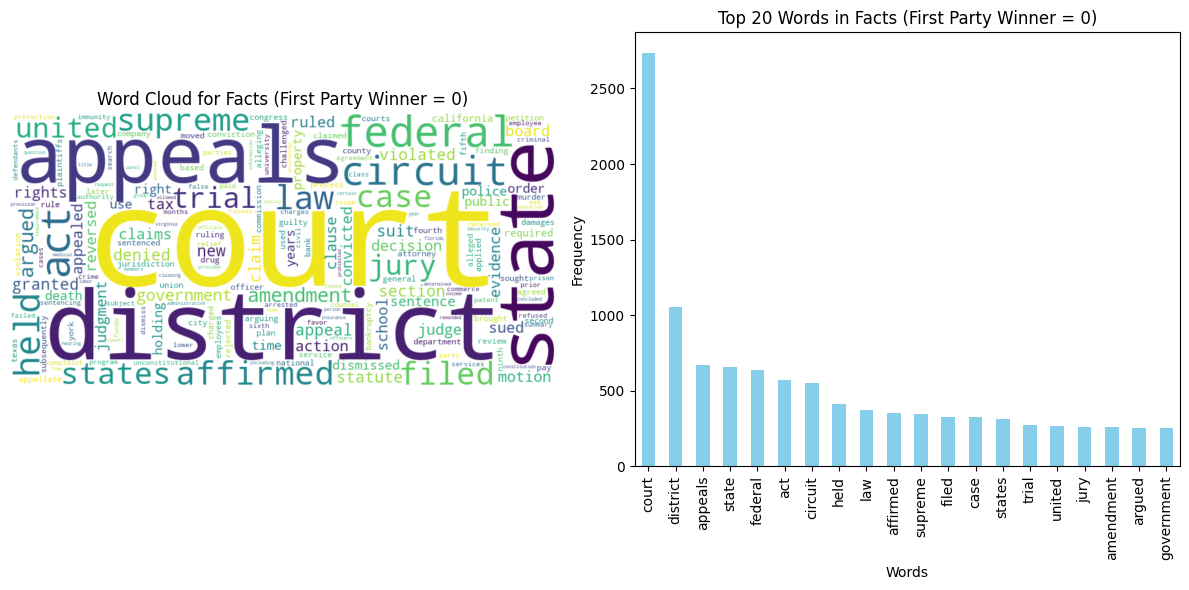

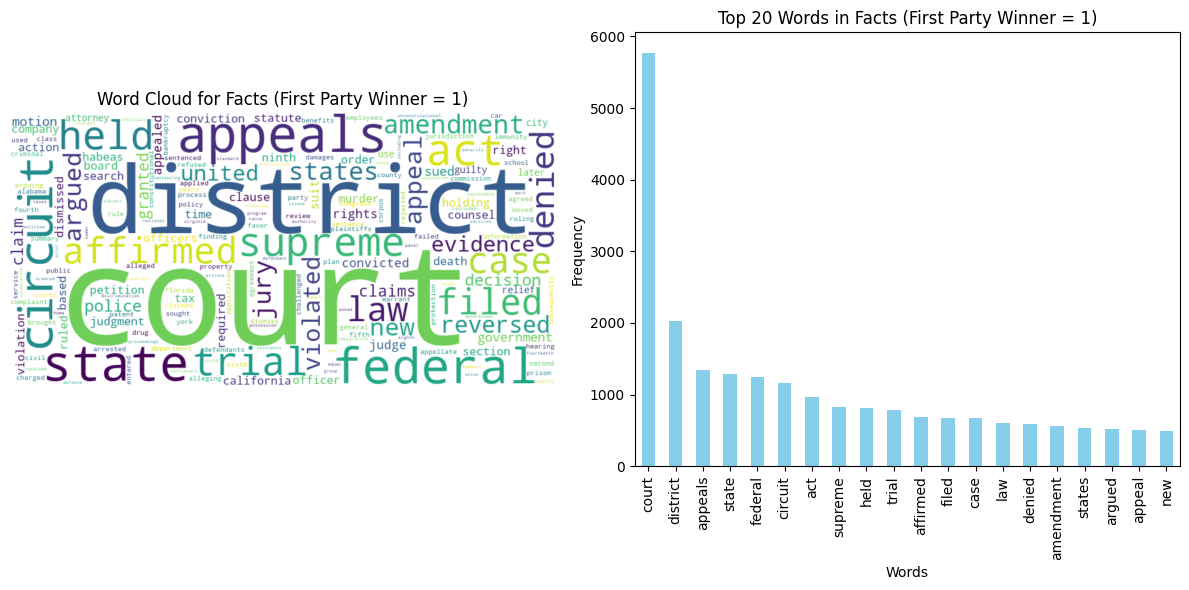

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 데이터 로드
train = pd.read_csv('train.csv')

# 판결이 0인 경우와 1인 경우로 데이터 나누기
facts_0 = train[train['first_party_winner'] == 0]['facts']
facts_1 = train[train['first_party_winner'] == 1]['facts']

# 불용어(stopwords) 설정
stop_words = set(stopwords.words('english')) | ENGLISH_STOP_WORDS

# 함수: 텍스트 데이터 전처리 및 시각화
def visualize_wordcloud(facts, title):
    # 텍스트 데이터 추출
    facts_text = ' '.join(facts.values)

    # 단어 토큰화
    tokens = word_tokenize(facts_text)

    # 불용어 제거
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word.isalpha()]

    # 단어 빈도수 계산
    word_freq = pd.Series(filtered_tokens).value_counts()

    # 워드클라우드 시각화
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Facts ({title})')

    # 단어 빈도수 히스토그램
    plt.subplot(1, 2, 2)
    word_freq.head(20).plot(kind='bar', color='skyblue')
    plt.title(f'Top 20 Words in Facts ({title})')
    plt.xlabel('Words')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# 시각화: 판결이 0일 때의 Word Cloud와 단어 빈도수 히스토그램
visualize_wordcloud(facts_0, 'First Party Winner = 0')

# 시각화: 판결이 1일 때의 Word Cloud와 단어 빈도수 히스토그램
visualize_wordcloud(facts_1, 'First Party Winner = 1')